# Spiking Neural Network with Eve

In this script, we will build a general spiking neural network with eve-mli, then we will further investigating the 
influence of different Node, i.e. IFNode and LIFNode combined with different surrotage functions.

In [1]:
# import necessary packages.
# at the beginning, ensure that the eve-mli package is in your python path.
# or you just install it via `pip install eve-mli`.

import os
import time
from datetime import datetime

import random
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import eve
import eve.app
import eve.app.model
import eve.app.trainer
import eve.core
import eve.app.space as space
import eve.core.layer

from matplotlib import pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
# build a basic network for trainer, use Poisson Encoder as default
class mnist(eve.core.Eve):
    def __init__(self,
                 timesteps: int = 5,
                 node: str="IFNode",
                 voltage_threshold: float = 1.0,
                 voltage_reset: float = 0.0,
                 learnable_threshold: bool = False,
                 learnable_reset: bool = False,
                 time_dependent: bool = True,
                 neuron_wise: bool = True,
                 surrogate_fn: str = "Sigmoid",
                 binary: bool = True,
                 **kwargs,):
        super().__init__()
        
        # we support IFNode and LIFNode, 
        # in non-spiking mode, the IFNode equals to a ReLU operation
        # the LIFNode equals to a LeakyReLU operation.
        node = getattr(eve.core.node, node)
        
        def build_node(state):
            return node(state, 
                        voltage_threshold=voltage_threshold,
                        voltage_reset=voltage_reset,
                        learnable_threshold=learnable_threshold,
                        learnable_reset=learnable_reset,
                        time_dependent=time_dependent,
                        neuron_wise=neuron_wise,
                        surrogate_fn=surrogate_fn,
                        binary=binary,
                        **kwargs,)
        
        self.encoder = eve.core.layer.PoissonEncoder(timesteps=timesteps)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(4),
        )
        self.node1 = build_node(eve.core.State(self.conv1))

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
        )
        self.node2 = build_node(eve.core.State(self.conv2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
        )
        self.node3 = build_node(eve.core.State(self.conv3))

        self.linear1 = nn.Linear(16 * 4 * 4, 16)
        self.node4 = build_node(eve.core.State(self.linear1))

        self.linear2 = nn.Linear(16, 10)

    def forward(self, x):
        encoder = self.encoder(x)
        
        conv1 = self.conv1(encoder)
        node1 = self.node1(conv1)

        conv2 = self.conv2(node1)
        node2 = self.node2(conv2)

        conv3 = self.conv3(node2)
        node3 = self.node3(conv3)

        node3 = th.flatten(node3, start_dim=1).unsqueeze(dim=1)

        linear1 = self.linear1(node3)
        node4 = self.node4(linear1)

        linear2 = self.linear2(node4)

        return linear2.squeeze(dim=1)

In [3]:
# define a MnistClassifier
# Classifier uses the corss entropy as default.
# in most case, we just rewrite the `prepare_data`.
class MnistClassifier(eve.app.model.Classifier):
    def prepare_data(self, data_root: str):
        from torch.utils.data import DataLoader, random_split
        from torchvision import transforms
        from torchvision.datasets import MNIST

        train_dataset = MNIST(root=data_root,
                              train=True,
                              download=True,
                              transform=transforms.ToTensor())
        test_dataset = MNIST(root=data_root,
                             train=False,
                             download=True,
                             transform=transforms.ToTensor())
        self.train_dataset, self.valid_dataset = random_split(
            train_dataset, [55000, 5000])
        self.test_dataset = test_dataset

        self.train_dataloader = DataLoader(self.train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=4)
        self.test_dataloader = DataLoader(self.test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=4)
        self.valid_dataloader = DataLoader(self.valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=4)
        
    def forward(self, batch_idx, batch, *args, **kwargs):
        # in spiking mode, you should reset the membrane voltage every time.
        self.reset()
        
        x, y = batch
        
        y_hat = [self.model(x) for _ in range(self.model.encoder.timesteps)]
        y_hat = th.stack(y_hat, dim=0).mean(dim=0)
        
        return {
            "loss": F.cross_entropy(y_hat, y),
            "acc": self._top_one_accuracy(y_hat, y),
        }

In [4]:
# store accuracy result
y = {}
def plot():
    global y
    keys, values = list(y.keys()), list(y.values())
    for k, v in y.items():
        plt.plot(v, 
                 color='green' if random.random() > 0.5 else "red", 
                 marker='o' if random.random() > 0.5 else "*", 
                 linestyle='-' if random.random() > 0.5 else ":", 
                 label=k)
    plt.title('accuracy over epoches (train)')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc="upper left")
    plt.show()

In [5]:
def train(net, exp_name: str = "snn", data_root: str = "/home/densechen/dataset"):
    global y
    # replace the data_root for your path.
    classifier = MnistClassifier(net)
    classifier.prepare_data(data_root=data_root)
    
    # use default configuration
    classifier.setup_train()
    
    # assign model to trainer
    eve.app.trainer.BaseTrainer.assign_model(classifier)
    
    trainer = eve.app.trainer.BaseTrainer()
    
    # train 10 epoches and report the final accuracy
    y[exp_name] = []
    tic = datetime.now()
    for _ in range(10):
        info = trainer.fit()
        y[exp_name].append(info["acc"])
    info = trainer.test()
    toc = datetime.now()
    y[exp_name] = np.array(y[exp_name])
    print(f"Test Accuracy: {info['acc']*100:.2f}%, Elapsed time: {toc-tic}")

# IFNode with different timesteps

===> timesteps: 1
Test Accuracy: 92.84%, Elapsed time: 0:01:00.376058
===> timesteps: 2
Test Accuracy: 95.23%, Elapsed time: 0:01:27.988771
===> timesteps: 5
Test Accuracy: 96.73%, Elapsed time: 0:02:39.402739
===> timesteps: 10
Test Accuracy: 96.38%, Elapsed time: 0:04:20.826122


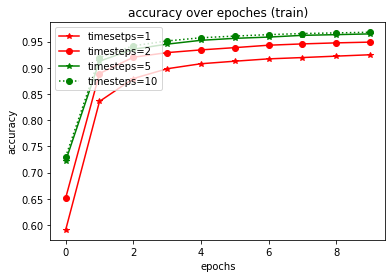

In [6]:
# reset y
y = {}

# define spiking neural network with different timesteps
ifnode_spiking_neural_network_1_timesteps = mnist(timesteps=1).spike()
ifnode_spiking_neural_network_2_timesteps = mnist(timesteps=2).spike()
ifnode_spiking_neural_network_5_timesteps = mnist(timesteps=5).spike()
ifnode_spiking_neural_network_10_timesteps = mnist(timesteps=10).spike()

# train and compare the influence of different timesteps.
print("===> timesteps: 1")
train(ifnode_spiking_neural_network_1_timesteps, "timesetps=1")

print("===> timesteps: 2")
train(ifnode_spiking_neural_network_2_timesteps, "timesteps=2")

print("===> timesteps: 5")
train(ifnode_spiking_neural_network_5_timesteps, "timesteps=5")

print("===> timesteps: 10")
train(ifnode_spiking_neural_network_10_timesteps, "timesteps=10")

plot()

# IFNode vs LIF Node

===> IFNode
Test Accuracy: 96.10%, Elapsed time: 0:02:40.809373
===> LIFNode, tau=1.0
Test Accuracy: 96.30%, Elapsed time: 0:02:54.205864


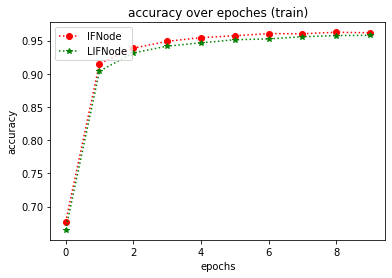

In [7]:
# reset y
y = {}

# define IFNode network
ifnode_spiking_neural_network = mnist(node="IFNode").spike()

# define LIFNode network
lifnode_spiking_neural_network = mnist(node="LIFNode", tau=1.0).spike()

# train and compare
print("===> IFNode")
train(ifnode_spiking_neural_network, "IFNode")

print("===> LIFNode, tau=1.0")
train(lifnode_spiking_neural_network, "LIFNode")

plot()

## IFNode with different configurations

===> IFNode learnable threshold
Test Accuracy: 95.34%, Elapsed time: 0:02:47.300100
===> IFNode learnable reset
Test Accuracy: 88.60%, Elapsed time: 0:02:44.121851
===> IFNode time independent
Test Accuracy: 96.38%, Elapsed time: 0:02:36.499136
===> IFNode neuron share
Test Accuracy: 95.99%, Elapsed time: 0:02:41.603358


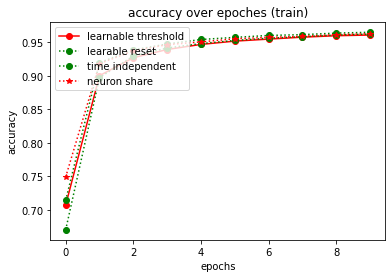

In [8]:
# reset y
y = {}

# define IFNode network with different configuration
ifnode_spiking_neural_network_learnable_threshold = mnist(learnable_threshold = True).spike()
print("===> IFNode learnable threshold")
train(ifnode_spiking_neural_network_learnable_threshold, "learnable threshold")

ifnode_spiking_neural_network_learnable_reset = mnist(learnable_reset=True).spike()
print("===> IFNode learnable reset")
train(ifnode_spiking_neural_network_learnable_reset, "learable reset")

ifnode_spiking_neural_network_time_independent = mnist(time_dependent=False).spike()
print("===> IFNode time independent")
train(ifnode_spiking_neural_network_time_independent, "time independent")

ifnode_spiking_neural_network_neuron_share = mnist(neuron_wise=False).spike()
print("===> IFNode neuron share")
train(ifnode_spiking_neural_network_neuron_share, "neuron share")

plot()

## IFNode with different surrogate functions

===> IFNode PiecewiseQuadratic
Test Accuracy: 96.59%, Elapsed time: 0:02:50.522003
===> IFNode SoftSign
Test Accuracy: 96.74%, Elapsed time: 0:02:46.623716
===> IFNode ATan
Test Accuracy: 94.56%, Elapsed time: 0:02:44.426878
===> IFNode NonzeroSignLogAbs
Test Accuracy: 95.71%, Elapsed time: 0:02:39.817249
===> IFNode Erf
Test Accuracy: 26.70%, Elapsed time: 0:02:43.860484
===> IFNode PiecewiseLeakyReLU
Test Accuracy: 96.82%, Elapsed time: 0:02:47.646427


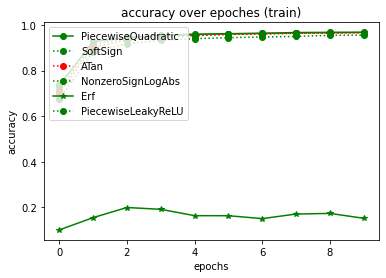

In [9]:
# reset y
y = {}

ifnode_spiking_neural_network_PiecewiseQuadratic = mnist(surrogate_fn="PiecewiseQuadratic").spike()
print("===> IFNode PiecewiseQuadratic")
train(ifnode_spiking_neural_network_PiecewiseQuadratic, "PiecewiseQuadratic")

ifnode_spiking_neural_network_SoftSign = mnist(surrogate_fn="SoftSign").spike()
print("===> IFNode SoftSign")
train(ifnode_spiking_neural_network_SoftSign, "SoftSign")

ifnode_spiking_neural_network_ATan = mnist(surrogate_fn="ATan").spike()
print("===> IFNode ATan")
train(ifnode_spiking_neural_network_ATan, "ATan")

ifnode_spiking_neural_network_NonzeroSignLogAbs = mnist(surrogate_fn="NonzeroSignLogAbs").spike()
print("===> IFNode NonzeroSignLogAbs")
train(ifnode_spiking_neural_network_NonzeroSignLogAbs, "NonzeroSignLogAbs")

ifnode_spiking_neural_network_Erf = mnist(surrogate_fn="Erf").spike()
print("===> IFNode Erf")
train(ifnode_spiking_neural_network_Erf, "Erf")

ifnode_spiking_neural_network_PiecewiseLeakyReLU = mnist(surrogate_fn="PiecewiseLeakyReLU").spike()
print("===> IFNode PiecewiseLeakyReLU")
train(ifnode_spiking_neural_network_PiecewiseLeakyReLU, "PiecewiseLeakyReLU")

plot()

## Hybrid

===> Hybrid Spiking Neural Network
Test Accuracy: 96.68%, Elapsed time: 0:04:11.330691


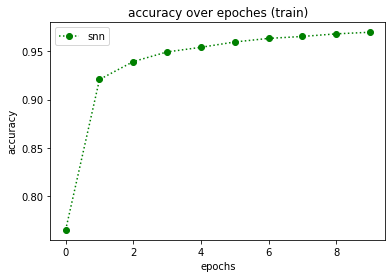

In [10]:
# reset y
y = {}

spiking_neural_network = mnist(
                 timesteps = 10,
                 node ="IFNode",
                 voltage_threshold = 1.0,
                 voltage_reset = 0.0,
                 learnable_threshold = False,
                 learnable_reset = True,
                 time_dependent = True,
                 neuron_wise = True,
                 surrogate_fn = "SoftSign",
                 binary = True,).spike()
print("===> Hybrid Spiking Neural Network")
train(spiking_neural_network)

plot()